# ATL08 v6 mapping of processed, filtered, & extracted covar tiled parquets


In [1]:
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd
import s3fs

In [2]:
ICESAT2_BOREAL_REPO_PATH = '/projects/code/icesat2_boreal'               #'/projects/icesat2_boreal' # /projects/Developer/icesat2_boreal/lib
ICESAT2_BOREAL_LIB_PATH = ICESAT2_BOREAL_REPO_PATH + '/lib'
import sys, os
import glob

sys.path.append(ICESAT2_BOREAL_LIB_PATH)
import CovariateUtils
import maplib_folium
import mosaiclib
from mosaiclib import *
import extract_atl08_covars

from pathlib import Path
import importlib
import folium
import contextily as ctx

NASA MAAP


ModuleNotFoundError: No module named 'contextily'

In [3]:
import time

In [4]:
import importlib
import mosaiclib
importlib.reload(mosaiclib)
from mosaiclib import *

In [ ]:
pip install lonboard

## Part 1: Read Boreal Tile Geopackage w/ locations of tiles

For now, we read in the existing geopackage from the earlier version.  Read the geopackage in as a geopandas dataframe.

In [10]:
# Boreal Tiles 
boreal_tiles_model_ready_fn = '/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg'
boreal_tiles = gpd.read_file(boreal_tiles_model_ready_fn)

In [11]:
len(boreal_tiles)

4956

### Build tindex of ATL08 filt 30m extract covars

In [9]:
YEAR_ATL08 = 2019
FROM_EXTRACT_COVARS = True

In [10]:
DICT_BUILD_TINDEX_ATL08_FILT = {
    'SET': 'ATL08',
    'USER': 'montesano',
    'ALG_NAME': 'process_atl08_boreal',
    'ALG_VERSION': 'process_atl08_boreal',
    'VAR': 'ATL08_filt',
    'BATCH_NAME': f'030m/{YEAR_ATL08}',
    'YEAR': 2024,
    'DPS_MONTH_LIST': '02 03',
    'DPS_DAY_MIN': 1,
    'TILES_INDEX_PATH': '/projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg'
}

if FROM_EXTRACT_COVARS:
    DICT_BUILD_TINDEX_ATL08_FILT['ALG_NAME'] = 'run_extract_atl08_covars'
    DICT_BUILD_TINDEX_ATL08_FILT['ALG_VERSION'] = 'extract_atl08_covars'
    DICT_BUILD_TINDEX_ATL08_FILT['BATCH_NAME'] = f'{YEAR_ATL08}'

DICT_BUILD_TINDEX = DICT_BUILD_TINDEX_ATL08_FILT

In [404]:
%%time

DPS_IDENTIFIER = f"{DICT_BUILD_TINDEX['ALG_VERSION']}/{DICT_BUILD_TINDEX['BATCH_NAME']}"
#DPS_IDENTIFIER = f"{DICT_BUILD_TINDEX['ALG_VERSION']}"
OUTDIR = f"/projects/my-public-bucket/DPS_tile_lists/{DICT_BUILD_TINDEX['SET']}/{DPS_IDENTIFIER}"
!mkdir -p $OUTDIR

# Build tindex
args = f"--RETURN_DUPS --user {DICT_BUILD_TINDEX['USER']} --dps_identifier {DPS_IDENTIFIER} \
-alg_name {DICT_BUILD_TINDEX['ALG_NAME']} -t {DICT_BUILD_TINDEX['VAR']} -y {DICT_BUILD_TINDEX['YEAR']} \
--dps_month_list {DICT_BUILD_TINDEX['DPS_MONTH_LIST']} -d_min {DICT_BUILD_TINDEX['DPS_DAY_MIN']} --outdir {OUTDIR} \
-boreal_tile_index_path {DICT_BUILD_TINDEX['TILES_INDEX_PATH']}"

if DICT_BUILD_TINDEX['ALG_VERSION'] == 'process_atl08_boreal':
    args += ' --SLIDERULE_OUT'
print(args)

!time /projects/env/above/bin/python /projects/code/icesat2_boreal/lib/build_tindex_master.py $args #--WRITE_TINDEX_MATCHES_GDF

--RETURN_DUPS --user montesano --dps_identifier extract_atl08_covars/2019 -alg_name run_extract_atl08_covars -t ATL08_filt -y 2024 --dps_month_list 02 03 -d_min 1 --outdir /projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/2019 -boreal_tile_index_path /projects/shared-buckets/montesano/databank/boreal_tiles_v004_model_ready.gpkg
NASA MAAP
INFO: Pandarallel will run on 25 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
NASA MAAP

Building a list of tiles:
DPS ID:		extract_atl08_covars/2019
Type:		ATL08_filt
Year:		['2024']
Month:		['02', '03']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/2019
Multiprocessing n obs with pandarallel...
# of duplicate tiles: 6
Final # of tiles: 4869
Writing duplicates csv: /projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/2019/ATL08_filt_tindex_master_duplicates.csv
Writing tindex master csv: /projects/my-publ

## Map tiles with extracted covars

In [11]:
from pylab import *

cmap = cm.get_cmap('inferno', 5)  #magma inferno plasma  
cmap_hex_list = []
for i in range(cmap.N):
    rgba = cmap(i)
    # rgb2hex accepts rgb or rgba
    cmap_hex_list.append(matplotlib.colors.rgb2hex(rgba))
cmap_hex_list

/tmp/ipykernel_159/2315283293.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno', 5)  #magma inferno plasma


['#000004', '#57106e', '#bc3754', '#f98e09', '#fcffa4']

In [12]:
import branca
import branca.colormap as cm

pal_nobs_cmap = cm.LinearColormap(colors=['red']+cmap_hex_list,index=[0,1e2,5e3,1e4,2e4,5e4], vmin=0,vmax=5e4)
pal_nobs_cmap

In [13]:
# YEAR_ATL08 = '2019'
# if YEAR_ATL08 == 'c2020':
#     ATL08_filt_tindex = pd.concat(pd.read_csv(ATL08_FILT_TINDEX_FN_DICT[f]) for f in ['c2020spring2022', 'c2020_v005'])
# else:
#     ATL08_filt_tindex = pd.read_csv(f'/projects/my-public-bucket/DPS_tile_lists/ATL08/process_atl08_boreal/030m/{YEAR_ATL08}/ATL08_filt_tindex_master.csv')
#     #ATL08_filt_tindex = pd.read_csv(f'/projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/{YEAR_ATL08}/ATL08_filt_tindex_master.csv')

In [14]:
import cartopy.crs as ccrs
crs_nstereo=ccrs.NorthPolarStereo()

In [15]:
MAP_EXTRACT_DF = False

In [ ]:
m = boreal_tiles.explore(color='gray',
                                  #tiles=maplib_folium.tiler_basemap_image, 
                                  tiles=maplib_folium.tiler_basemap_gray, 
                                  attr=' ', legend_kwds={'caption': '# filtered ATL08 30m obs.'} )

for YEAR_ATL08 in list(range(2019,2020+1)):
    
    print(YEAR_ATL08)
    
    if MAP_EXTRACT_DF:
        ATL08_filt_tindex = pd.read_csv(f'/projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/{YEAR_ATL08}/ATL08_filt_tindex_master.csv')
    else:
        ATL08_filt_tindex = pd.read_csv(f'/projects/my-public-bucket/DPS_tile_lists/ATL08/process_atl08_boreal/030m/{YEAR_ATL08}/ATL08_filt_tindex_master.csv')
    
    if YEAR_ATL08 == 'c2020':
        ATL08_filt_tindex = pd.concat(pd.read_csv(ATL08_FILT_TINDEX_FN_DICT[f]) for f in ['c2020spring2022', 'c2020_v005'])
        
    if YEAR_ATL08 == 2019:
        boreal_tiles_ATL08_filt = boreal_tiles[['tile_num','n_obs','geometry']].merge(ATL08_filt_tindex[['tile_num', 'n_obs']], on='tile_num', suffixes = ['.atl08v005',f'.atl08v006_{YEAR_ATL08}'])
    else:
        ATL08_filt_tindex[f'n_obs.atl08v006_{YEAR_ATL08}'] = ATL08_filt_tindex['n_obs']
        boreal_tiles_ATL08_filt = boreal_tiles_ATL08_filt.merge(ATL08_filt_tindex[['tile_num', f'n_obs.atl08v006_{YEAR_ATL08}']], on='tile_num')
    
    #print(boreal_tiles_ATL08_filt.columns.to_list())
        
    m=boreal_tiles_ATL08_filt.explore(m=m, column=f'n_obs.atl08v006_{YEAR_ATL08}', cmap=pal_nobs_cmap, legend=True)
    #ax = boreal_tiles_ATL08_filt.to_crs(3857).plot(column=f'n_obs.atl08v006_{YEAR_ATL08}', cmap='inferno', legend=True, figsize=(13,3))
    #ctx.add_basemap(ax, source = ctx.providers.Esri.WorldGrayCanvas, crs=3857)

folium.LayerControl().add_to(m)
m

In [335]:
OVERALL_SUM = 0
for YEAR_ATL08 in list(range(2019,2023+1)):
    
    YEAR_SUM = sum(boreal_tiles_ATL08_filt[f'n_obs.atl08v006_{YEAR_ATL08}'])
    print(f"{YEAR_SUM:,} v006 filtered 30m ATL08 obs in {YEAR_ATL08} with extracted covariates across {boreal_tiles_ATL08_filt.shape[0]} tiles")
    OVERALL_SUM += YEAR_SUM

print(f"{sum(boreal_tiles_ATL08_filt['n_obs.atl08v005']):,} v005 filtered 30m ATL08 obs with extracted covariates across {boreal_tiles_ATL08_filt.shape[0]} tiles")
print(f"{OVERALL_SUM:,} v006 filtered 30m ATL08 obs from 2019-2023 with extracted covariates across {boreal_tiles_ATL08_filt.shape[0]} tiles")


36,284,216 v006 filtered 30m ATL08 obs in 2019 with extracted covariates across 4956 tiles
58,738,236 v006 filtered 30m ATL08 obs in 2020 with extracted covariates across 4956 tiles
36,140,548 v006 filtered 30m ATL08 obs in 2021 with extracted covariates across 4956 tiles
57,014,315 v006 filtered 30m ATL08 obs in 2022 with extracted covariates across 4956 tiles
35,291,043 v006 filtered 30m ATL08 obs in 2023 with extracted covariates across 4956 tiles
25,132,074 v005 filtered 30m ATL08 obs with extracted covariates across 4956 tiles
223,468,358 v006 filtered 30m ATL08 obs from 2019-2023 with extracted covariates across 4956 tiles


## Stats on tiled ATL08 observations

In [ ]:
def get_atl08_meta_df(YEAR_ATL08):
    print(YEAR_ATL08)
    atl08_meta_df = pd.concat([pd.read_csv(f) for f in glob.glob(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/{YEAR_ATL08}/*.csv')])
    print(f'{sum(atl08_meta_df.sliderule):,} v006 30m ATL08 for tile from sliderule')
    print(f"{sum(atl08_meta_df['seasonal_6-9']):,} v006 30m ATL08 for tile after quality filtering")
    print(f"Filtering cuts out {round(100*(1-sum(atl08_meta_df['seasonal_6-9'])/sum(atl08_meta_df['sliderule'])),1)}% of observations from sliderule params set")
    atl08_meta_df = atl08_meta_df.reset_index().drop(['index','Unnamed: 0'],axis=1)
    atl08_meta_df['year'] = YEAR_ATL08
    atl08_meta_df.to_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/atl08_006_030m_{YEAR_ATL08}_{YEAR_ATL08}_06_09_filt_metadata.parquet')

YEARS_WITH_META_CSV = [2019,2022,2023]
[get_atl08_meta_df(YEAR_ATL08) for YEAR_ATL08 in [2023]]

In [274]:
atl08_meta_df = pd.concat([pd.read_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/atl08_006_030m_{YEAR_ATL08}_{YEAR_ATL08}_06_09_filt_metadata.parquet') for YEAR_ATL08 in YEARS_WITH_META_CSV])
atl08_meta_df.head()

,sliderule,msw_flag=0,beam_type=strong,snowcover=1,h_can threshold (lc),misc thresholds,seasonal_6-9,tile_num,year
0,43749,9430,4754,322,216,96,96,4,2019
1,124031,60791,31104,17582,3818,1083,1083,9,2019
2,51940,19401,10014,1676,322,0,0,10,2019
3,132827,54961,28967,19278,15693,6067,6067,11,2019
4,75721,20070,10670,3658,2291,195,195,12,2019


In [344]:
smry = atl08_meta_df.groupby('year').agg(cnt_tiles=('year', 'count'), 
                                         median_cnt_filt_obs_year=('seasonal_6-9', 'median'), 
                                         std_cnt_filt_obs_year=('seasonal_6-9', 'std'),
                                         total_obs_sum=('seasonal_6-9','sum'),
                                         median_cnt_SR_obs_year=('sliderule', 'median'),
                                         median_obs_SR_sum=('sliderule', 'sum')
                                        )
smry

,cnt_tiles,median_cnt_filt_obs_year,std_cnt_filt_obs_year,total_obs_sum,median_cnt_SR_obs_year,median_obs_SR_sum
year,,,,,,
2019,4956,5910.0,6514.182859,36284216,83965.0,424719809
2022,4956,10026.5,8969.166761,57014315,108347.0,538557298
2023,4956,5561.5,6710.031579,35291043,118960.0,586547663


## Stats on number of ATL08 v6 observations per tile

Text(0.5, 0, '# ATL08 30m obs.')

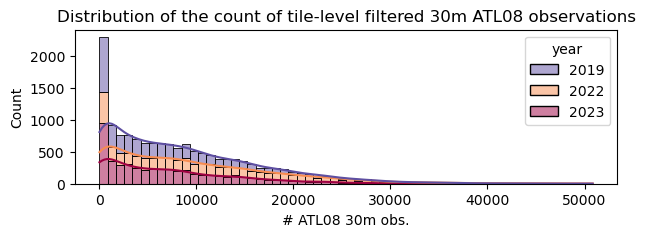

In [305]:
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,2))
ax = f.add_subplot(1,1,1)

# plot
import seaborn as sns

ax = sns.histplot(data=atl08_meta_df, ax=ax, stat="count", multiple="stack", #dodge
             x="seasonal_6-9", kde=True,
             palette="Spectral_r", hue="year", bins=60, legend=True )
ax.set_title(f"Distribution of the count of tile-level filtered 30m ATL08 observations")
ax.set_ylabel("Count")
ax.set_xlabel("# ATL08 30m obs.")

### Map Filtered Results after SlideRule ATL08 Re-Binning

Tiles :  
 - 1916 shows good diff between v6 and v5 ATL08 over low stature veg

In [395]:
importlib.reload(maplib_folium)

<module 'maplib_folium' from '/projects/code/icesat2_boreal/lib/maplib_folium.py'>

In [86]:
import maplib_folium
import branca.colormap as cm
pal_height_cmap = cm.LinearColormap(colors = ['black','#636363','#fc8d59','#fee08b','#ffffbf','#d9ef8b','#91cf60','#1a9850'], vmin=0, vmax=10)
pal_height_cmap.caption = 'Vegetation height from  ATL08 @ 30 m (h_can; rh98)'
pal_height_cmap

In [49]:
# # Get FOCAL_TILE_LIST from all that are processed
# FOCAL_TILE_LIST = boreal_tiles_ATL08_filt.tile_num.to_list()

# print(len(FOCAL_TILE_LIST))

In [408]:
# FOCAL_TILE_IDX = [i for i, tile_num in enumerate(FOCAL_TILE_LIST) if tile_num == 1842][0]
# FOCAL_TILE_IDX

# atl08_gdf_list = []
# for FOCAL_TILE in FOCAL_TILE_LIST[FOCAL_TILE_IDX:FOCAL_TILE_IDX+1]:
#     atl08_gdf_list.append(gpd.read_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/2020/atl08_006_030m_2020_2020_06_09_filt_{FOCAL_TILE:05}.parquet'))

1707

In [5]:
FOCAL_TILE = 2913 #2668 #3009
YEAR_ATL08 = 2020

In [6]:
SEWARD_TILE_LIST = [3543,3544,3545, 
                   3637,3638,3639,
                   3732,3732,3733]

In [14]:
boreal_tiles[boreal_tiles.tile_num.isin(SEWARD_TILE_LIST)].explore()

In [8]:

atl08_list = []
for FOCAL_TILE in SEWARD_TILE_LIST:
    atl08_list.append( gpd.read_parquet(f'/projects/my-private-bucket/data/process_atl08_boreal/030m/{YEAR_ATL08}/atl08_006_030m_{YEAR_ATL08}_{YEAR_ATL08}_06_09_filt_{FOCAL_TILE:05}.parquet') )
atl08 = pd.concat(atl08_list)
atl08.shape

(100451, 44)

In [9]:
atl08.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 100451 entries, 44559 to 146914
Data columns (total 44 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   h_max_canopy          100451 non-null  float32 
 1   canopy_openness       100266 non-null  float32 
 2   solar_elevation       100451 non-null  float32 
 3   gnd_ph_count          100451 non-null  uint32  
 4   veg_ph_count          100451 non-null  uint32  
 5   snowcover             100451 non-null  uint8   
 6   landcover             100451 non-null  uint8   
 7   h_min_canopy          100451 non-null  float32 
 8   h_mean_canopy         100266 non-null  float32 
 9   segment_id            100451 non-null  uint32  
 10  cycle                 100451 non-null  uint16  
 11  rgt                   100451 non-null  uint16  
 12  gt                    100451 non-null  uint8   
 13  x_atc                 100451 non-null  float64 
 14  extent_id             100451 

In [37]:
def tile_reader(fn):
    tile_num = int(os.path.splitext(fn)[0].split('_')[-1])
    gdf = gpd.read_parquet(fn)
    gdf['tile_num'] = tile_num
    gdf['file'] = os.path.basename(fn)
    return gdf

def chunker(seq, size):
    return [seq[pos:pos + size] for pos in range(0, len(seq), size)]

In [38]:
smry_cnt_orig_list = []
smry_cnt_dropdups_list = []
atl08_gdf_list = []
maindir = '/projects/my-private-bucket/data/process_atl08_boreal/030m'

for FOCAL_TILE_LIST in chunker(boreal_tiles.tile_num.to_list(), 100):
#for FOCAL_TILE_LIST in [SEWARD_TILE_LIST]:
    for FOCAL_TILE in FOCAL_TILE_LIST:
        # Get the tindex for each each
        fn_list = glob.glob(f'{maindir}/**/atl08_006_030m_*_06_09_filt_*{FOCAL_TILE:05}.parquet') 
        if len(fn_list) > 0:
            atl08_gdf = pd.concat([tile_reader(fn) for fn in fn_list])
            #smry_cnt_orig_list.append(atl08_gdf.groupby(['file','tile_num','y']).aggregate(n_obs_year = ('tile_num', 'count')).reset_index())
            #smry_cnt_dropdups_list.append(atl08_gdf.drop_duplicates().groupby(['file','tile_num','y']).aggregate(n_obs_year = ('y', 'count')).reset_index())
    
            atl08_gdf_list.append(atl08_gdf)

In [39]:
atl08_gdf = pd.concat(atl08_gdf_list)
s1 = atl08_gdf.groupby(['file','tile_num','y']).aggregate(n_obs_year = ('tile_num', 'count')).reset_index()
s2 = atl08_gdf.drop_duplicates().groupby(['file','tile_num','y']).aggregate(n_obs_year = ('y', 'count')).reset_index()

sm = s1.merge(s2, how='outer', on=['file','tile_num','y'], suffixes=['_orig', '_nodups'])
sm['dif'] = sm.n_obs_year_orig - sm.n_obs_year_nodups
sm

,file,tile_num,y,n_obs_year_orig,n_obs_year_nodups,dif
0,atl08_006_030m_2019_2019_06_09_filt_003543.par...,3543,2019,2225,2225,0
1,atl08_006_030m_2019_2019_06_09_filt_003544.par...,3544,2019,3209,3209,0
2,atl08_006_030m_2019_2019_06_09_filt_003545.par...,3545,2019,11,11,0
3,atl08_006_030m_2019_2019_06_09_filt_003637.par...,3637,2019,4774,4774,0
4,atl08_006_030m_2019_2019_06_09_filt_003638.par...,3638,2019,7610,7610,0
5,atl08_006_030m_2019_2019_06_09_filt_003639.par...,3639,2019,53,53,0
6,atl08_006_030m_2019_2019_06_09_filt_003732.par...,3732,2019,11062,5531,5531
7,atl08_006_030m_2019_2019_06_09_filt_003733.par...,3733,2019,261,261,0
8,atl08_006_030m_2020_2020_06_09_filt_03543.parquet,3543,2020,525,525,0
9,atl08_006_030m_2020_2020_06_09_filt_03544.parquet,3544,2020,17366,17366,0


In [26]:
atl08.groupby(['segment_landcover']).aggregate(n_obs_lc = ('segment_landcover', 'count')).reset_index()

,segment_landcover,n_obs_lc
0,20,7903
1,30,8580
2,60,9
3,100,11
4,111,1086
5,113,3
6,116,1159
7,121,38
8,123,3
9,126,5107


In [17]:
atl08.columns

Index(['ph_count', 'spot', 'h_canopy', 'segment_id', 'h_te_median',
       'h_mean_canopy', 'extent_id', 'solar_elevation', 'gnd_ph_count',
       'veg_ph_count', 'h_min_canopy', 'rgt', 'snowcover', 'cycle',
       'canopy_openness', 'x_atc', 'gt', 'h_max_canopy', 'landcover',
       'geometry', 'h_dif_ref', 'msw_flag', 'sigma_topo', 'segment_landcover',
       'segment_snowcover', 'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80',
       'rh85', 'rh90', 'rh95', 'h_canopy_uncertainty', 'segment_cover',
       'h_te_uncertainty', 'y', 'm', 'd', 'doy', 'beam_type'],
      dtype='object')

Text(0.5, 0, 'Height from ATL08 30m obs.')

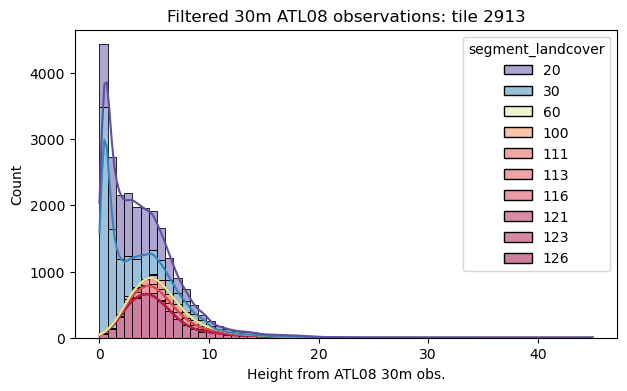

In [30]:
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,4))
ax = f.add_subplot(1,1,1)

# plot
import seaborn as sns

ax = sns.histplot(data=atl08[atl08.h_canopy > 0], ax=ax, stat="count", multiple="stack", #dodge
             x="h_canopy", kde=True,
             palette="Spectral_r", hue="segment_landcover", bins=60, legend=True )
ax.set_title(f"Filtered 30m ATL08 observations: tile {FOCAL_TILE}")
ax.set_ylabel("Count")
ax.set_xlabel("Height from ATL08 30m obs.")

#### Map relative uncertainty of h_canopy

In [56]:
# # Compute relative h_can_uncertainty
# atl08['h_can_uncert_rel'] = round(atl08['h_canopy_uncertainty'] / atl08['h_canopy'], 3)

In [ ]:
m = boreal_tiles[boreal_tiles.tile_num == FOCAL_TILE].boundary.explore(color='red', tiles=maplib_folium.tiler_basemap_image, attr=' ')
m = atl08.explore(m=m, column='h_canopy', cmap=pal_height_cmap, legend=True, vmax=20)
m = atl08.explore(m=m, column='h_can_uncert_rel', cmap='inferno', legend=True, vmax=1, style_kwds={"style_function":lambda x: {"radius":x["properties"]["h_canopy"]}})
folium.LayerControl().add_to(m)
m

In [65]:
ATL08_FILT_TINDEX_FN_DICT

{'c2020spring2022': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt/c2020/tile_atl08/ATL08_filt_tindex_master.csv',
 'c2020fall2022v1': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_gedi_rh/ATL08_filt_tindex_master.csv',
 'c2020fall2022v2': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv',
 'c2020_v005': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/tile_atl08/c2020_v005/ATL08_filt_tindex_master.csv'}

# Comparitve mapping
## Map ATL08 v6 from sliderule

In [120]:
importlib.reload(maplib_folium)

<module 'maplib_folium' from '/projects/code/icesat2_boreal/lib/maplib_folium.py'>

In [ ]:
maplib_folium.map_tile_atl08([FOCAL_TILE], None, boreal_tiles, ATL08_filt_tindex_master_fn = atl08,
                             DO_NIGHT=False,
                  map_width = 600, map_height=1200, OVERVIEW_MAP= True,
                  max_AGB_display = 50, max_AGBSE_display = 20
                 )

## Map ATL08 v5 from Phase 2

In [84]:
# Here are Phase 2 filtered ATL08 tindex files
ATL08_FILT_TINDEX_FN_DICT

{'c2020spring2022': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt/c2020/tile_atl08/ATL08_filt_tindex_master.csv',
 'c2020fall2022v1': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_gedi_rh/ATL08_filt_tindex_master.csv',
 'c2020fall2022v2': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv',
 'c2020_v005': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/tile_atl08/c2020_v005/ATL08_filt_tindex_master.csv'}

In [ ]:
maplib_folium.map_tile_atl08(FOCAL_TILE, None, boreal_tiles, ATL08_filt_tindex_master_fn = ATL08_FILT_TINDEX_FN_DICT['c2020spring2022'], DO_NIGHT=False,
                  map_width = 600, map_height=1200, OVERVIEW_MAP= True,
                  max_AGB_display = 50, max_AGBSE_display = 20
                 )

# Investigating ATL08 format differences from `Version 5` to `Version 6`

In [409]:
ATL08_FILT_TINDEX_FN_DICT

{'c2020spring2022': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt/c2020/tile_atl08/ATL08_filt_tindex_master.csv',
 'c2020fall2022v1': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_gedi_rh/ATL08_filt_tindex_master.csv',
 'c2020fall2022v2': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/fall2022/with_atl03_rh/ATL08_filt_tindex_master.csv',
 'c2020_v005': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/tile_atl08/c2020_v005/ATL08_filt_tindex_master.csv',
 '2019': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2019/ATL08_filt_tindex_master.csv',
 '2020': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2020/ATL08_filt_tindex_master.csv',
 '2021': None,
 '2022': 's3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2022/ATL08_filt_tindex_master.csv',
 '2023': 's3://maap-ops-workspace/shared/montesano/DPS_tile_list

In [419]:
# v5 tindex
ATL08v5_tindex_2020 = pd.read_csv(ATL08_FILT_TINDEX_FN_DICT['c2020spring2022'])
# v6 tindex
ATL08v6_tindex_2020 = pd.read_csv(ATL08_FILT_TINDEX_FN_DICT['2020'])

In [411]:
# Check these tiles
CHECK_TILES = [2815,2816]

In [425]:
# Get the paths of those check tiles
v5_check_tile_fn_list = ATL08v5_tindex_2020[ATL08v5_tindex_2020.tile_num.isin(CHECK_TILES)].s3_path.to_list()
v6_check_tile_fn_list = ATL08v6_tindex_2020[ATL08v6_tindex_2020.tile_num.isin(CHECK_TILES)].s3_path.to_list()

### `Version 6` tiled/filtered/extracted-covars ATL08 parquets:
1. have more columns (SlideRule gave us more ATL08 cols, and we left them there for use later)  
2. have varying columns arrangements (but consistent column names)  
3. have inconsistent number of fields from SlideRule  (elaboration a few chunks below) 
4. have some columns named differently from `Version 5`  

These is annoying differences from the `Version 5` counterparts, but shouldnt be a problem, b/c downstream we select the column names we need to AGB modeling

In [414]:
v6_chk_1 = gpd.read_parquet(v6_check_tile_fn_list[0])
v6_chk_1.columns

Index(['extent_id', 'spot', 'gnd_ph_count', 'segment_id', 'h_te_median',
       'snowcover', 'h_max_canopy', 'canopy_openness', 'rgt', 'h_mean_canopy',
       'cycle', 'solar_elevation', 'veg_ph_count', 'h_canopy', 'x_atc', 'gt',
       'h_min_canopy', 'ph_count', 'landcover', 'geometry', 'h_dif_ref',
       'msw_flag', 'sigma_topo', 'segment_landcover', 'segment_snowcover',
       'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80', 'rh85', 'rh90', 'rh95',
       'h_canopy_uncertainty', 'segment_cover', 'h_te_uncertainty', 'y', 'm',
       'd', 'doy', 'beam_type', 'elevation', 'slope', 'tsri', 'tpi',
       'slopemask', 'Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2', 'NDVI',
       'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCB', 'TCG', 'TCW',
       'ValidMask', 'Xgeo', 'Ygeo', 'JulianDate', 'yearDate',
       'vv_median_frozen', 'vh_median_frozen', 'vv_median_summer',
       'vh_median_summer', 'vv_median_shoulder', 'vh_median_shoulder',
       'n_frozen', 'n_summer', 'n_shoulder'],

In [415]:
v6_chk_2 = gpd.read_parquet(v6_check_tile_fn_list[1])
v6_chk_2.columns

Index(['h_max_canopy', 'spot', 'solar_elevation', 'h_te_median', 'h_canopy',
       'segment_id', 'cycle', 'x_atc', 'gt', 'rgt', 'canopy_openness',
       'gnd_ph_count', 'h_mean_canopy', 'ph_count', 'extent_id',
       'h_min_canopy', 'snowcover', 'landcover', 'veg_ph_count', 'geometry',
       'binsize', 'num_bins', 'h_dif_ref', 'msw_flag', 'sigma_topo',
       'segment_landcover', 'segment_snowcover', 'rh25', 'rh50', 'rh60',
       'rh70', 'rh75', 'rh80', 'rh85', 'rh90', 'rh95', 'h_canopy_uncertainty',
       'segment_cover', 'h_te_uncertainty', 'y', 'm', 'd', 'doy', 'beam_type',
       'elevation', 'slope', 'tsri', 'tpi', 'slopemask', 'Blue', 'Green',
       'Red', 'NIR', 'SWIR', 'SWIR2', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI',
       'NBR', 'NBR2', 'TCB', 'TCG', 'TCW', 'ValidMask', 'Xgeo', 'Ygeo',
       'JulianDate', 'yearDate', 'vv_median_frozen', 'vh_median_frozen',
       'vv_median_summer', 'vh_median_summer', 'vv_median_shoulder',
       'vh_median_shoulder', 'n_frozen', 'n_

### Inconsistent number of columns from SlideRule

For some unknown, SlideRule-related reason, some `Version 6` ATL08 have 2 additional, unnecessary fields

this could mess up column indexing - should identify columns explicitly with their names

In [417]:
print(len(v6_chk_1.columns))
print(len(v6_chk_2.columns))

77
79


In [418]:
set(v6_chk_1.columns).symmetric_difference(set(v6_chk_2.columns))

{'binsize', 'num_bins'}

### `Version 5` tiled/filtered/extracted-covars ATL08 csvs have names that are sometime different than their `Version 6` counterparts
but these are NOT the covar field names (from topo, HLS, S1) - so this difference shouldnt matter  
example:  
v5 name = `sol_el`  
v6 name = `solar_elevation`

In [77]:
v5_chk_1 = pd.read_csv(v5_check_tile_fn_list[0])
v5_chk_1.columns

Index(['lon', 'lat', 'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80', 'rh90',
       'h_can', 'h_max_can', 'ter_slp', 'h_te_best', 'seg_landcov', 'sol_el',
       'y', 'm', 'doy', 'seg_cover', 'geometry', 'elevation', 'slope', 'tsri',
       'tpi', 'slopemask', 'Blue', 'Green', 'Red', 'NIR', 'SWIR', 'SWIR2',
       'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2', 'TCB', 'TCG',
       'TCW', 'ValidMask', 'Xgeo', 'Ygeo', 'JulianDate', 'yearDate'],
      dtype='object')

## Example: merge neighbors

In [45]:
TILE_NUM = 2032
f'/projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/{YEAR_ATL08}/ATL08_filt_tindex_master.csv'

'/projects/my-public-bucket/DPS_tile_lists/ATL08/extract_atl08_covars/2020/ATL08_filt_tindex_master.csv'

In [46]:
args = f'-in_tile_num {TILE_NUM} \
-in_tile_fn {boreal_tile_index_path} \
-in_tile_field tile_num \
-csv_list_fn s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2020/ATL08_filt_tindex_master.csv \
-DPS_DATA_USER montesano \
-out_dir /projects/my-public-bucket/local_output'

In [47]:
!python /projects/code/icesat2_boreal/lib/merge_neighbors_atl08.py $args

Neighbor tile ids for tile 2032: [1962, 1963, 1964, 2031, 2033, 2101, 2102, 2103]
# of neighbor tiles: 8
Reading ATL08 tile index: s3://maap-ops-workspace/shared/montesano/DPS_tile_lists/ATL08/extract_atl08_covars/2020/ATL08_filt_tindex_master.csv
Found: s3://maap-ops-workspace/montesano/dps_output/run_extract_atl08_covars/extract_atl08_covars/2020/2024/02/28/07/27/42/719447/atl08_006_030m_2020_2020_06_09_filt_covars_002032.parquet
# of neighbor tiles with filtered ATL08 geodataframes with extracted covariates: 8 
Wrote out: /projects/my-public-bucket/local_output/atl08_006_030m_2020_2020_06_09_filt_covars_merge_neighbors_002032.parquet
Focal tile + neighbors shape: (103346, 79)
Adding lat, lon fields & dropping geometry field for CSV output...
Wrote out: /projects/my-public-bucket/local_output/atl08_006_030m_2020_2020_06_09_filt_covars_merge_neighbors_002032.csv


In [48]:
atl08_merge_neighbors = gpd.read_parquet(f'/projects/my-public-bucket/local_output/atl08_006_030m_2020_2020_06_09_filt_covars_merge_neighbors_{TILE_NUM:06}.parquet')
atl08_merge_neighbors.shape

(103346, 79)

In [49]:
atl08_merge_neighbors.columns

Index(['extent_id', 'canopy_openness', 'h_te_median', 'rgt', 'h_max_canopy',
       'gnd_ph_count', 'solar_elevation', 'snowcover', 'h_mean_canopy',
       'segment_id', 'gt', 'h_min_canopy', 'spot', 'ph_count', 'veg_ph_count',
       'landcover', 'cycle', 'h_canopy', 'x_atc', 'geometry', 'num_bins',
       'binsize', 'h_dif_ref', 'msw_flag', 'sigma_topo', 'segment_landcover',
       'segment_snowcover', 'rh25', 'rh50', 'rh60', 'rh70', 'rh75', 'rh80',
       'rh85', 'rh90', 'rh95', 'h_canopy_uncertainty', 'segment_cover',
       'h_te_uncertainty', 'y', 'm', 'd', 'doy', 'beam_type', 'elevation',
       'slope', 'tsri', 'tpi', 'slopemask', 'Blue', 'Green', 'Red', 'NIR',
       'SWIR', 'SWIR2', 'NDVI', 'SAVI', 'MSAVI', 'NDMI', 'EVI', 'NBR', 'NBR2',
       'TCB', 'TCG', 'TCW', 'ValidMask', 'Xgeo', 'Ygeo', 'JulianDate',
       'yearDate', 'vv_median_frozen', 'vh_median_frozen', 'vv_median_summer',
       'vh_median_summer', 'vv_median_shoulder', 'vh_median_shoulder',
       'n_frozen', 'n_

In [50]:
atl08_merge_neighbors[['landcover','segment_landcover']][0:20]

,landcover,segment_landcover
35086,111,111
35090,111,111
35094,111,111
35098,111,111
35102,111,111
35106,111,111
35110,111,111
35114,111,111
35118,111,111
35123,111,111


In [379]:
m = boreal_tiles[boreal_tiles.tile_num == TILE_NUM].boundary.explore(color='red', tiles=maplib_folium.tiler_basemap_image, attr=' ')
m = atl08_merge_neighbors.sample(frac=0.01).explore(m=m, column='h_canopy', cmap=pal_height_cmap, legend=True, vmax=20)
folium.LayerControl().add_to(m)
m

### View many points with lonboard

In [51]:
from lonboard import viz

viz(atl08_merge_neighbors)

/opt/conda/envs/pangeo/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(basemap_style=<CartoBasemap.DarkMatter: 'https://basemaps.cartocdn.com/gl/dark-matter-gl-style/style.json'…

In [53]:
from pathlib import Path

import geopandas as gpd
import numpy as np
import pandas as pd
import shapely
from palettable.colorbrewer.diverging import BrBG_10

from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap

In [54]:
layer = ScatterplotLayer.from_geopandas(atl08_merge_neighbors)
m = Map(layer)
m

/opt/conda/envs/pangeo/lib/python3.10/site-packages/lonboard/_geoarrow/ops/reproject.py:97: UserWarning: Input being reprojected to EPSG:4326 CRS
  warnings.warn("Input being reprojected to EPSG:4326 CRS")


Map(layers=[ScatterplotLayer(table=pyarrow.Table
extent_id: uint64
canopy_openness: float
h_te_median: float
r…